**Imports**

PyTorch Geometric

In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 5.2 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 4.0 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 5.0 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 4.9 MB/s 
     |████████████████████████████████| 407 kB 4.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=aca19a4c44d417ce4dff0fc6edd69aef2b70b82b1c16ae67637be88dc06dd46f
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [60]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sn

from torch_geometric.data import InMemoryDataset, download_url, Data
from torch.utils.data import random_split
from datetime import datetime
from torch.nn import Linear
from IPython.display import Javascript
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from datetime import timedelta
from sklearn.metrics import confusion_matrix

**Mount GDrive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
action_types.csv              participants_activity_anomalies.csv
activities.csv                patients.csv
activity_types.csv            scores.csv
anomalies.csv                 scores_predictions.csv
anomaly_types.csv             sensor_locations.csv
diagnosis_predictions.csv     sensors.csv
diagnosis_types.csv           tasks.csv
events.csv                    task_types.csv
overt_error_action_types.csv  trajectory_anomalies.csv


In [26]:
len(pd.read_csv('drive/MyDrive/CASAS400/sensor_locations.csv').query('sensor_id == "m052"'))

0

# Riconoscimento di diagnosi paziente

In [ ]:
def task_activity_sensors(tasks, events, sensors, activities, patient):

  # Seleziona i task-activity eseguiti dal paziente 'patient'
  task_activity = tasks.query('patient == ' + patient)

  # Seleziona il tempo di inizio e fine delle attività svolte dal paziente 'patient'
  activities_patient = activities.query('patient == ' + patient)
  start_time = activities_patient.iloc[0]['start']
  end_time = activities_patient.iloc[len(activities_patient) - 1]['end']

  # Query nel dataframe events per selezionare solo i sensori utilizzati nelle attività
  sensors_events = events.query('patient == ' + patient + ' and time >= "' + start_time + '" and time <= "' + end_time + '"')

  # Matrice risultato che contiene i dati dei nodi
  res_node = pd.DataFrame(columns=['features'])
  res_edge = pd.DataFrame(columns=['times']) 

  # Dimensione dell'array delle features
  dim_features = len(sensors)

  # Dizionario che contiene la posizione del sensore nell'array delle features
  dict_sens = {}

  for i in range(0, dim_features):
    dict_sens[sensors.iloc[i]['sensor_id']] = i

  # Indice del task-activity
  i = 0

  # Numero edge del grafo
  num_edge = 0

  # Nome del task-activity precedente
  pair_str_prev = ""

  # Flag per salvataggio features di nodo e arco
  ins_upd = False
  last_node = False

  for i in range(0, len(task_activity)):

    # Controlla se il task-activity attuale è l'ultimo
    if ((i + 1) >= len(task_activity)):
      last_node = True

    # Nome del task-activity attuale
    pair_str = str(task_activity.iloc[i]['task']) + '-' + str(task_activity.iloc[i]['activity'])

    # Controlla se il task-activity attuale e quello precedente sono diversi
    if pair_str != pair_str_prev:

      # Viene salvato lo start time
      s_time = task_activity.iloc[i]['time']

      # Controlla se il task-activity attuale non è l'ultimo
      if not last_node:

        # Controlla se il task-activity attuale e quello successivo sono diversi
        if pair_str != str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']):

          # Viene salvato l'end time
          e_time = task_activity.iloc[i + 1]['time']

          ins_upd = True
          pair_str_prev = pair_str

        else:
          ins_upd = False
          pair_str_prev = pair_str
      
      else:

        # Viene salvato l'end time
        e_time = end_time

        ins_upd = True
        pair_str_prev = pair_str
    
    else:
      # Controlla se il task-activity attuale non è l'ultimo
      if not last_node:

        # Controlla se il task-activity attuale e quello successivo sono diversi
        if pair_str != str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']):

          # Viene salvato l'end time
          e_time = task_activity.iloc[i + 1]['time']

          ins_upd = True
          pair_str_prev = pair_str
        
        else:
          ins_upd = False
          pair_str_prev = pair_str
      
      else:

        # Viene salvato l'end time
        e_time = end_time

        ins_upd = True
        pair_str_prev = pair_str

    # Controlla se start ed end time sono stati trovati
    if ins_upd:

      # Controlla se il task-activity attuale non è l'ultimo
      if not last_node:

        # Aggiorna il numero di edge del grafo
        num_edge = num_edge + 1

        # Controlla se esiste un arco per il task-activity attuale 
        if pair_str in res_edge.index:

          # Aggiunge start ed end time all'arco
          res_edge.loc[pair_str, 'times'] += [((s_time, e_time), str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']))]
        
        else:
          # Crea un nuovo arco
          res_edge.loc[pair_str] = [[((s_time, e_time), str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']))]]

      # Controlla se non esiste un nodo per il task-activity attuale
      if not pair_str in res_node.index:

        # Crea un array vuoto per le fueatures del nodo
        features_node = np.zeros(dim_features, dtype=np.int8)

        # Seleziona i sensori utilizzati per il task-activity attuale
        task_activity_sensors = sensors_events.query('time >= "' + s_time + '" and time <= "' + e_time + '"')

        # Popola l'array delle features
        for _, s in task_activity_sensors.iterrows():
          features_node[dict_sens[s['sensor']]] = 1

        # Salva nel nodo l'array delle features
        res_node.loc[pair_str] = [features_node]
  
  return res_edge, res_node, num_edge

In [ ]:
sensors = pd.read_csv('drive/MyDrive/CASAS400/sensors.csv')
events = pd.read_csv('drive/MyDrive/CASAS400/events.csv')
tasks = pd.read_csv('drive/MyDrive/CASAS400/tasks.csv')
activities = pd.read_csv('drive/MyDrive/CASAS400/activities.csv')

patients = pd.read_csv('drive/MyDrive/CASAS400/activities.csv')['patient'].unique()

dataset = []

for i in range(0, len(patients)):

  # Crea i dataframe con le features degli edges e dei nodi
  edge, node, num_edge = task_activity_sensors(tasks, events, sensors, activities, str(patients[i]))

  # Salva la label associata al paziente
  label = pd.read_csv('drive/MyDrive/CASAS400/patients.csv').query('patient_id == ' + str(patients[i]))['diagnosis'].values

  if len(node) > 0:
    atr_node = np.zeros([len(node), len(node.iloc[0]['features'])])

    # Converte il dataframe dei nodi in una matrice
    for j in range(0, len(node)):
      atr_node[j] = node.iloc[j]['features']

    adj_matrix = np.empty([num_edge, 2])
    index_adj_matrix = 0

    # Crea la matrice di addiacenza dei nodi
    for j in range(0, len(edge)):
      for k in range(0, len(edge.iloc[j]['times'])):
        f_node = node.index.get_loc(edge.iloc[j].name)
        s_node = node.index.get_loc(edge.iloc[j]['times'][k][1])

        adj_matrix[index_adj_matrix] = np.array([f_node, s_node])
        index_adj_matrix = index_adj_matrix + 1
    
    # Salva la mtrice delle features e la matrice di addiacenza del grafo
    dataset.append(Data(x=torch.tensor(atr_node, dtype=torch.float),
                        edge_index=torch.tensor(adj_matrix, dtype=torch.long).t().contiguous(),
                        y=torch.tensor(label, dtype=torch.long)))

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


In [ ]:
diagnosis = pd.read_csv('drive/MyDrive/CASAS400/diagnosis_types.csv')['diagnosis_id']

dim_label = pd.DataFrame(columns=['label', 'dimension'])

count = 0

for d in diagnosis:
  count = 0
  for item in dataset:
    if item.y[0] == d:
      count = count + 1
  
  dim_label = dim_label.append({'label': d, 'dimension': count}, ignore_index = True)

# Riconoscimento di attività paziente

Matrice contatore

In [ ]:
def activity_graph(tasks, events, sensors, activities, patient, activity):

  # Seleziona il tempo di inizio e fine delle attività svolte dal paziente 'patient'
  activities_patient = activities.query('patient == ' + patient + ' and activity_type == ' + activity)
  start_time = activities_patient.iloc[0]['start']
  end_time = activities_patient.iloc[len(activities_patient) - 1]['end']

  # Query nel dataframe events per selezionare solo i sensori utilizzati nelle attività
  sensors_events = events.query('patient == ' + patient + ' and time >= "' + start_time + '" and time <= "' + end_time + '"')

  # Matrice risultato che contiene i dati dei nodi
  res_node = pd.DataFrame(columns=['features'])
  res_edge = pd.DataFrame(columns=['times']) 

  # Dimensione dell'array delle features
  dim_features = len(sensors)

  # Dizionario che contiene la posizione del sensore nell'array delle features
  dict_sens = {}

  for i in range(0, dim_features):
    dict_sens[sensors.iloc[i]['sensor_id']] = i

  task_activity = tasks.query('patient == ' + patient + ' and activity == ' + activity)

  # Indice del task-activity
  i = 0

  # Numero edge del grafo
  num_edge = 0

  # Nome del task-activity precedente
  pair_str_prev = ""

  # Flag per salvataggio features di nodo e arco
  ins_upd = False
  last_node = False

  for i in range(0, len(task_activity)):

    # Controlla se il task-activity attuale è l'ultimo
    if ((i + 1) >= len(task_activity)):
      last_node = True

    # Nome del task-activity attuale
    pair_str = str(task_activity.iloc[i]['task']) + '-' + str(task_activity.iloc[i]['activity'])

    # Controlla se il task-activity attuale e quello precedente sono diversi
    if pair_str != pair_str_prev:

      # Viene salvato lo start time
      s_time = task_activity.iloc[i]['time']

      # Controlla se il task-activity attuale non è l'ultimo
      if not last_node:

        # Controlla se il task-activity attuale e quello successivo sono diversi
        if pair_str != str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']):

          # Viene salvato l'end time
          e_time = task_activity.iloc[i + 1]['time']

          ins_upd = True
          pair_str_prev = pair_str

        else:
          ins_upd = False
          pair_str_prev = pair_str
      
      else:

        # Viene salvato l'end time
        e_time = end_time

        ins_upd = True
        pair_str_prev = pair_str
    
    else:
      # Controlla se il task-activity attuale non è l'ultimo
      if not last_node:

        # Controlla se il task-activity attuale e quello successivo sono diversi
        if pair_str != str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']):

          # Viene salvato l'end time
          e_time = task_activity.iloc[i + 1]['time']

          ins_upd = True
          pair_str_prev = pair_str
        
        else:
          ins_upd = False
          pair_str_prev = pair_str
      
      else:

        # Viene salvato l'end time
        e_time = end_time

        ins_upd = True
        pair_str_prev = pair_str

    # Controlla se start ed end time sono stati trovati
    if ins_upd:

      # Controlla se il task-activity attuale non è l'ultimo
      if not last_node:

        # Aggiorna il numero di edge del grafo
        num_edge = num_edge + 1

        # Controlla se esiste un arco per il task-activity attuale 
        if pair_str in res_edge.index:

          # Aggiunge start ed end time all'arco
          res_edge.loc[pair_str, 'times'] += [((s_time, e_time), str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']))]
        
        else:
          # Crea un nuovo arco
          res_edge.loc[pair_str] = [[((s_time, e_time), str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']))]]

      # Controlla se non esiste un nodo per il task-activity attuale
      if not pair_str in res_node.index:

        # Crea un array vuoto per le fueatures del nodo
        features_node = np.zeros(dim_features, dtype=np.int8)

        # Seleziona i sensori utilizzati per il task-activity attuale
        task_activity_sensors = sensors_events.query('time >= "' + s_time + '" and time <= "' + e_time + '"')

        # Popola l'array delle features
        for _, s in task_activity_sensors.iterrows():
          if s['sensor'].startswith('m') and s['value'] == 'on':
            features_node[dict_sens[s['sensor']]] += 1
            
          elif not s['sensor'].startswith('m'):
            features_node[dict_sens[s['sensor']]] += 1

        # Salva nel nodo l'array delle features
        res_node.loc[pair_str] = [features_node]
  
  return res_edge, res_node, num_edge

Matrice binaria

In [ ]:
def activity_graph(tasks, events, sensors, activities, patient, activity):

  # Seleziona il tempo di inizio e fine delle attività svolte dal paziente 'patient'
  activities_patient = activities.query('patient == ' + patient + ' and activity_type == ' + activity)
  start_time = activities_patient.iloc[0]['start']
  end_time = activities_patient.iloc[len(activities_patient) - 1]['end']

  # Query nel dataframe events per selezionare solo i sensori utilizzati nelle attività
  sensors_events = events.query('patient == ' + patient + ' and time >= "' + start_time + '" and time <= "' + end_time + '"')

  # Matrice risultato che contiene i dati dei nodi
  res_node = pd.DataFrame(columns=['features'])
  res_edge = pd.DataFrame(columns=['times']) 

  # Dimensione dell'array delle features
  dim_features = len(sensors)

  # Dizionario che contiene la posizione del sensore nell'array delle features
  dict_sens = {}

  for i in range(0, dim_features):
    dict_sens[sensors.iloc[i]['sensor_id']] = i

  task_activity = tasks.query('patient == ' + patient + ' and activity == ' + activity)

  # Indice del task-activity
  i = 0

  # Numero edge del grafo
  num_edge = 0

  # Nome del task-activity precedente
  pair_str_prev = ""

  # Flag per salvataggio features di nodo e arco
  ins_upd = False
  last_node = False

  for i in range(0, len(task_activity)):

    # Controlla se il task-activity attuale è l'ultimo
    if ((i + 1) >= len(task_activity)):
      last_node = True

    # Nome del task-activity attuale
    pair_str = str(task_activity.iloc[i]['task']) + '-' + str(task_activity.iloc[i]['activity'])

    # Controlla se il task-activity attuale e quello precedente sono diversi
    if pair_str != pair_str_prev:

      # Viene salvato lo start time
      s_time = task_activity.iloc[i]['time']

      # Controlla se il task-activity attuale non è l'ultimo
      if not last_node:

        # Controlla se il task-activity attuale e quello successivo sono diversi
        if pair_str != str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']):

          # Viene salvato l'end time
          e_time = task_activity.iloc[i + 1]['time']

          ins_upd = True
          pair_str_prev = pair_str

        else:
          ins_upd = False
          pair_str_prev = pair_str
      
      else:

        # Viene salvato l'end time
        e_time = end_time

        ins_upd = True
        pair_str_prev = pair_str
    
    else:
      # Controlla se il task-activity attuale non è l'ultimo
      if not last_node:

        # Controlla se il task-activity attuale e quello successivo sono diversi
        if pair_str != str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']):

          # Viene salvato l'end time
          e_time = task_activity.iloc[i + 1]['time']

          ins_upd = True
          pair_str_prev = pair_str
        
        else:
          ins_upd = False
          pair_str_prev = pair_str
      
      else:

        # Viene salvato l'end time
        e_time = end_time

        ins_upd = True
        pair_str_prev = pair_str

    # Controlla se start ed end time sono stati trovati
    if ins_upd:

      # Controlla se il task-activity attuale non è l'ultimo
      if not last_node:

        # Aggiorna il numero di edge del grafo
        num_edge = num_edge + 1

        # Controlla se esiste un arco per il task-activity attuale 
        if pair_str in res_edge.index:

          # Aggiunge start ed end time all'arco
          res_edge.loc[pair_str, 'times'] += [((s_time, e_time), str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']))]
        
        else:
          # Crea un nuovo arco
          res_edge.loc[pair_str] = [[((s_time, e_time), str(task_activity.iloc[i + 1]['task']) + '-' + str(task_activity.iloc[i + 1]['activity']))]]

      # Controlla se non esiste un nodo per il task-activity attuale
      if not pair_str in res_node.index:

        # Crea un array vuoto per le fueatures del nodo
        features_node = np.zeros(dim_features, dtype=np.int8)

        # Seleziona i sensori utilizzati per il task-activity attuale
        task_activity_sensors = sensors_events.query('time >= "' + s_time + '" and time <= "' + e_time + '"')

        # Popola l'array delle features
        for _, s in task_activity_sensors.iterrows():
          if s['sensor'].startswith('m') and s['value'] == 'on':
            features_node[dict_sens[s['sensor']]] = 1
            
          elif not s['sensor'].startswith('m'):
            features_node[dict_sens[s['sensor']]] = 1

        # Salva nel nodo l'array delle features
        res_node.loc[pair_str] = [features_node]
  
  return res_edge, res_node, num_edge

In [ ]:
sensors = pd.read_csv('drive/MyDrive/CASAS400/sensors.csv')
events = pd.read_csv('drive/MyDrive/CASAS400/events.csv')
tasks = pd.read_csv('drive/MyDrive/CASAS400/tasks.csv')
activities = pd.read_csv('drive/MyDrive/CASAS400/activities.csv')

patients = pd.read_csv('drive/MyDrive/CASAS400/activities.csv')['patient'].unique()

dataset = []

for i in range(0, len(patients)):

  patient_activities = activities.query('patient == ' + str(patients[i]))['activity_type'].unique()

  for act in patient_activities:

    # Salva la label associata al grafo dell'attività corrispondente
    label = np.array([act - 1])

    # Crea i dataframe con le features degli edges e dei nodi
    edge, node, num_edge = activity_graph(tasks, events, sensors, activities, str(patients[i]), str(act))

    if len(node) > 0:
      atr_node = np.zeros([len(node), len(node.iloc[0]['features'])])

      # Converte il dataframe dei nodi in una matrice
      for k in range(0, len(node)):
        atr_node[k] = node.iloc[k]['features']

      adj_matrix = np.empty([num_edge, 2])
      index_adj_matrix = 0

      # Crea la matrice di addiacenza dei nodi
      for k in range(0, len(edge)):
        for x in range(0, len(edge.iloc[k]['times'])):
          f_node = node.index.get_loc(edge.iloc[k].name)
          s_node = node.index.get_loc(edge.iloc[k]['times'][x][1])

          adj_matrix[index_adj_matrix] = np.array([f_node, s_node])
          index_adj_matrix = index_adj_matrix + 1
      
      # Salva la mtrice delle features e la matrice di addiacenza del grafo
      dataset.append(Data(x=torch.tensor(atr_node, dtype=torch.float),
                          edge_index=torch.tensor(adj_matrix, dtype=torch.long).t().contiguous(),
                          y=torch.tensor(label, dtype=torch.long)))

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


Finestre temporali

In [17]:
def from_str_to_time(ts):
  h, m, s = ts.split(':')
  return timedelta(hours=int(h), minutes=int(m), seconds=float(s))

Finsetre temporali con sensori nei nodi

In [ ]:
def activity_graph(tasks, events, sensors, activities, patient, activity):

  # Seleziona il tempo di inizio e fine delle attività svolte dal paziente 'patient'
  activities_patient = activities.query('patient == ' + patient + ' and activity_type == ' + activity)
  start_time = activities_patient.iloc[0]['start']
  end_time = activities_patient.iloc[len(activities_patient) - 1]['end']

  # Query nel dataframe events per selezionare solo i sensori utilizzati nelle attività
  sensors_events = events.query('patient == ' + patient + ' and time >= "' + start_time + '" and time <= "' + end_time + '"')
  start_time = from_str_to_time(start_time)
  end_time = from_str_to_time(end_time)

  # Matrice risultato che contiene i dati dei nodi
  res_node = pd.DataFrame(columns=['features'])
  res_edge = pd.DataFrame(columns=['times']) 

  # Dimensione dell'array delle features
  dim_features = len(sensors)

  # Dizionario che contiene la posizione del sensore nell'array delle features
  dict_sens = {}

  for i in range(0, dim_features):
    dict_sens[sensors.iloc[i]['sensor_id']] = i

  # Indice del task-activity
  i = 0

  # Numero edge del grafo
  num_edge = 0


  # Flag per salvataggio features di nodo e arco
  last_node = False

  # Tempo iniziale della finestra temporale
  s_time = start_time

  while s_time < end_time:

    e_time = s_time + from_str_to_time('00:00:30.0')

    # Controlla se la finestra temporale attuale è l'ultima
    if e_time >= end_time:
      last_node = True

      # Controlla se la finetra temporale attuale supera l'end time dell'attività
      if e_time > end_time:
        e_time = end_time

    # Controlla se il task-activity attuale non è l'ultimo
    if not last_node:

      # Aggiorna il numero di edge del grafo
      num_edge = num_edge + 1

      # Crea un nuovo arco
      res_edge.loc[len(res_node.index)] = [(s_time, e_time)]

    # Crea un array vuoto per le fueatures del nodo
    features_node = np.zeros(dim_features, dtype=np.int8)

    # Seleziona i sensori utilizzati per il task-activity attuale
    task_activity_sensors = sensors_events.query('time >= "' + str(s_time) + '" and time <= "' + str(e_time) + '"')

    # Popola l'array delle features
    for _, s in task_activity_sensors.iterrows():
      if s['sensor'].startswith('m') and s['value'] == 'on':
        features_node[dict_sens[s['sensor']]] = 1
            
      elif not s['sensor'].startswith('m'):
        features_node[dict_sens[s['sensor']]] = 1

    # Salva nel nodo l'array delle features
    res_node.loc[len(res_node.index)] = [features_node]

    # Aggiorna s_time
    s_time = e_time
  
  return res_edge, res_node, num_edge

In [ ]:
sensors = pd.read_csv('drive/MyDrive/CASAS400/sensors.csv')
events = pd.read_csv('drive/MyDrive/CASAS400/events.csv')
tasks = pd.read_csv('drive/MyDrive/CASAS400/tasks.csv')
activities = pd.read_csv('drive/MyDrive/CASAS400/activities.csv')

patients = pd.read_csv('drive/MyDrive/CASAS400/activities.csv')['patient'].unique()

dataset = []

for i in range(0, len(patients)):

  patient_activities = activities.query('patient == ' + str(patients[i]))['activity_type'].unique()

  for act in patient_activities:

    # Salva la label associata al grafo dell'attività corrispondente
    label = np.array([act - 1])

    # Crea i dataframe con le features degli edges e dei nodi
    edge, node, num_edge = activity_graph(tasks, events, sensors, activities, str(patients[i]), str(act))

    if len(node) > 0:
      atr_node = np.zeros([len(node), len(node.iloc[0]['features'])])

      # Converte il dataframe dei nodi in una matrice
      for k in range(0, len(node)):
        atr_node[k] = node.iloc[k]['features']

      adj_matrix = np.empty([num_edge, 2])
      index_adj_matrix = 0

      # Crea la matrice di adiacenza dei nodi
      for k in range(0, len(edge) - 1):
        f_node = node.index.get_loc(edge.iloc[k].name)
        s_node = node.index.get_loc(edge.iloc[k + 1].name)

        adj_matrix[index_adj_matrix] = np.array([f_node, s_node])
        index_adj_matrix = index_adj_matrix + 1
      
      # Salva la mtrice delle features e la matrice di adiacenza del grafo
      dataset.append(Data(x=torch.tensor(atr_node, dtype=torch.float),
                          edge_index=torch.tensor(adj_matrix, dtype=torch.long).t().contiguous(),
                          y=torch.tensor(label, dtype=torch.long)))

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


Finestre temporali con un sensore per nodo

In [27]:
def activity_graph(tasks, events, sensors, sensor_locations, desc_dict, activities, patient, activity):

  # Seleziona il tempo di inizio e fine delle attività svolte dal paziente 'patient'
  activities_patient = activities.query('patient == ' + patient + ' and activity_type == ' + activity)
  start_time = activities_patient.iloc[0]['start']
  end_time = activities_patient.iloc[len(activities_patient) - 1]['end']

  # Query nel dataframe events per selezionare solo i sensori utilizzati nelle attività
  sensors_events = events.query('patient == ' + patient + ' and time >= "' + start_time + '" and time <= "' + end_time + '"')
  start_time = from_str_to_time(start_time)
  end_time = from_str_to_time(end_time)

  # Matrice risultato che contiene i dati dei nodi
  res_node = pd.DataFrame(columns=['features'])
  res_edge = pd.DataFrame(columns=['times']) 

  # Numero edge del grafo
  num_edge = 0

  # Flag per salvataggio features di nodo e arco
  last_node = False
  last_node_time_window = False

  # Tempo iniziale della finestra temporale
  s_time = start_time

  while s_time < end_time:

    e_time = s_time + from_str_to_time('00:00:30.0')

    # Controlla se la finestra temporale attuale è l'ultima
    if e_time >= end_time:
      last_node = True

      # Controlla se la finetra temporale attuale supera l'end time dell'attività
      if e_time > end_time:
        e_time = end_time

    # Seleziona i sensori utilizzati per il task-activity attuale
    task_activity_sensors = sensors_events.query('time >= "' + str(s_time) + '" and time <= "' + str(e_time) + '"')

    task_activity_sensors_used = task_activity_sensors[task_activity_sensors['value'].str.contains('on|open|present')].reset_index()

    # Popola l'array delle features
    for i, s in task_activity_sensors_used.iterrows():

      if i < len(task_activity_sensors_used) - 1:

        # Controlla se il sensore attuale non è l'ultimo
        if not last_node:

          if last_node_time_window:

            # Controlla se esiste un arco per il sensore attuale
            if tmp_sensor in res_edge.index:

              # Controlla se non esiste già un edge con lo stessa coppia di timestamps
              if (tmp_time, str(task_activity_sensors_used.iloc[i]['sensor'])) not in res_edge.loc[tmp_sensor, 'times']:

                # Aggiorna il numero di edge del grafo
                num_edge = num_edge + 1

                # Aggiunge start ed end time all'arco
                res_edge.loc[tmp_sensor, 'times'] += [(tmp_time, str(task_activity_sensors_used.iloc[i]['sensor']))]
                last_node_time_window = False

            else:

              # Crea un nuovo arco che collega la finestra temporale attuale con quella precedente
              res_edge.loc[tmp_sensor] = [[(tmp_time, str(task_activity_sensors_used.iloc[i]['sensor']))]]
              last_node_time_window = False

              # Aggiorna il numero di edge del grafo
              num_edge = num_edge + 1
            

          # Controlla se esiste un arco per il sensore attuale
          if s['sensor'] in res_edge.index:

            # Controlla se non esiste già un edge con lo stessa coppia di timestamps
            if ((s_time, e_time), str(task_activity_sensors_used.iloc[i + 1]['sensor'])) not in res_edge.loc[s['sensor'], 'times']:

              # Aggiorna il numero di edge del grafo
              num_edge = num_edge + 1

              # Aggiunge start ed end time all'arco
              res_edge.loc[s['sensor'], 'times'] += [((s_time, e_time), str(task_activity_sensors_used.iloc[i + 1]['sensor']))]
              
          else:
            # Aggiorna il numero di edge del grafo
            num_edge = num_edge + 1

            # Crea un nuovo arco
            res_edge.loc[s['sensor']] = [[((s_time, e_time), str(task_activity_sensors_used.iloc[i + 1]['sensor']))]]
      
      else:
        last_node_time_window = True
        tmp_time = (s_time, e_time)
        tmp_sensor = s['sensor']

      # Calcola il numero di volte che un sensore è stato utilizzato
      num_on = len(task_activity_sensors[task_activity_sensors['value'].str.contains('on|open|present')].query('sensor == "' + str(s['sensor']) + '"'))
      num_off = len(task_activity_sensors[task_activity_sensors['value'].str.contains('of|close|absent')].query('sensor == "' + str(s['sensor']) + '"'))

      # Controlla se esiste già un nodo per il sensore attuale
      if s['sensor'] in res_node.index:

        # Aggiorna l'array delle features
        res_node.loc[s['sensor']]['features'][0] += num_on
        res_node.loc[s['sensor']]['features'][1] += num_off
        
      else:
        sensor_type = desc_dict[sensors.query('sensor_id == "' + s['sensor'] + '"')['description'].values[0]]
        sensor_x = sensor_locations.query('sensor_id == "' + s['sensor'] + '"')
        sensor_y = sensor_locations.query('sensor_id == "' + s['sensor'] + '"')

        if len(sensor_x) > 0 and len(sensor_y) > 0:
          # Crea l'array delle features
          res_node.loc[s['sensor']] = [np.array([num_on, num_off, sensor_type, sensor_x['x'].values[0], sensor_y['y'].values[0]], dtype=object)]
        
        else:
          # Crea l'array delle features
          res_node.loc[s['sensor']] = [np.array([num_on, num_off, sensor_type, 0.0, 0.0], dtype=object)]

    # Aggiorna s_time
    s_time = e_time
  
  return res_edge, res_node, num_edge

In [15]:
def coder_type_sensors(sensors):

  desc_dict = {}
  i = 1

  for s in sensors:
    desc_dict[s] = i
    i += 1
  
  return desc_dict

In [28]:
sensors = pd.read_csv('drive/MyDrive/CASAS400/sensors.csv')
events = pd.read_csv('drive/MyDrive/CASAS400/events.csv')
tasks = pd.read_csv('drive/MyDrive/CASAS400/tasks.csv')
activities = pd.read_csv('drive/MyDrive/CASAS400/activities.csv')
sensor_locations = pd.read_csv('drive/MyDrive/CASAS400/sensor_locations.csv')

patients = pd.read_csv('drive/MyDrive/CASAS400/activities.csv')['patient'].unique()
desc_dict = coder_type_sensors(sensors['description'].unique())

dataset = []

for i in range(0, len(patients)):

  patient_activities = activities.query('patient == ' + str(patients[i]))['activity_type'].unique()

  for act in patient_activities:

    # Salva la label associata al grafo dell'attività corrispondente
    label = np.array([act - 1])

    # Crea i dataframe con le features degli edges e dei nodi
    edge, node, num_edge = activity_graph(tasks, events, sensors, sensor_locations, desc_dict, activities, str(patients[i]), str(act))

    if len(node) > 0:
      atr_node = np.zeros([len(node), len(node.iloc[0]['features'])])

      # Converte il dataframe dei nodi in una matrice
      for k in range(0, len(node)):
        atr_node[k] = node.iloc[k]['features']

      adj_matrix = np.empty([num_edge, 2])
      index_adj_matrix = 0

      # Crea la matrice di addiacenza dei nodi
      for k in range(0, len(edge)):
        for x in range(0, len(edge.iloc[k]['times'])):
          f_node = node.index.get_loc(edge.iloc[k].name)
          s_node = node.index.get_loc(edge.iloc[k]['times'][x][1])

          adj_matrix[index_adj_matrix] = np.array([f_node, s_node])
          index_adj_matrix = index_adj_matrix + 1
      
      # Salva la mtrice delle features e la matrice di addiacenza del grafo
      dataset.append(Data(x=torch.tensor(atr_node, dtype=torch.float),
                          edge_index=torch.tensor(adj_matrix, dtype=torch.long).t().contiguous(),
                          y=torch.tensor(label, dtype=torch.long)))

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


In [29]:
activities = pd.read_csv('drive/MyDrive/CASAS400/activities.csv')['activity_type'].drop_duplicates()
dim_label = pd.DataFrame(columns=['label', 'dimension'])

count = 0

for a in activities:
  count = 0
  for item in dataset:
    if item.y[0] == a - 1:
      count = count + 1
  
  dim_label = dim_label.append({'label': a - 1, 'dimension': count}, ignore_index = True)

# Split train e test

Split fisso del dataset

In [ ]:
def train_test_split(data, dim_label):

  train_mask = np.full(len(data), False)
  test_mask = np.full(len(data), False)

  for _, d in dim_label.iterrows():
    num_element = int(d['dimension'] * 0.8)

    for i in range(len(data)):

      if data[i].y[0] == d['label']:
        if num_element > 0:
          train_mask[i] = True
          num_element = num_element - 1
        
        else:
          test_mask[i] = True
    
  return train_mask, test_mask

In [ ]:
train = []
test = []

train_mask, test_mask = train_test_split(dataset, dim_label)

for i in range(len(dataset)):
  if train_mask[i] == True:
    train.append(dataset[i])
  
  else:
    test.append(dataset[i])

Split casuale del dataset

In [30]:
def get_label_data(data, label):

  label_data = []

  for i in range(len(data)):
    if data[i].y[0] == label:
      label_data.append(data[i])
  
  res = random_split(dataset=label_data, lengths=[int(0.8 * len(label_data)), len(label_data) - int(0.8 * len(label_data))], generator=torch.Generator().manual_seed(365))
  
  return res[0], res[1]

In [31]:
train = []
test = []

for _, d in dim_label.iterrows():

  label_train, label_test = get_label_data(dataset, d['label'])

  train.extend(list(label_train))
  test.extend(list(label_test))

In [32]:
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[458, 5], edge_index=[2, 1224], y=[64], batch=[458], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[460, 5], edge_index=[2, 1171], y=[64], batch=[460], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[474, 5], edge_index=[2, 1274], y=[64], batch=[474], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[458, 5], edge_index=[2, 1164], y=[64], batch=[458], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[450, 5], edge_index=[2, 1079], y=[64], batch=[450], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[447, 5], edge_index=[2, 1352], y=[64], batch=[447], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[481, 5], edge_index=[2, 1379], y=[64], batch=[481], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(x=[417, 5], edge_index=[2, 1103], y=[64], batch=[417], ptr

In [33]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(5, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 16)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(5, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=16, bias=True)
)


In [61]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

y_pred = []
y_true = []

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader, test_flag):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.

         if test_flag:
          y_pred.extend(pred)
          y_true.extend(data.y)

         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader, False)
    test_acc = test(test_loader, True)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.4330, Test Acc: 0.4155
Epoch: 002, Train Acc: 0.5197, Test Acc: 0.5093
Epoch: 003, Train Acc: 0.5673, Test Acc: 0.5289
Epoch: 004, Train Acc: 0.5890, Test Acc: 0.5602
Epoch: 005, Train Acc: 0.5749, Test Acc: 0.5347
Epoch: 006, Train Acc: 0.5828, Test Acc: 0.5787
Epoch: 007, Train Acc: 0.5618, Test Acc: 0.5544
Epoch: 008, Train Acc: 0.6120, Test Acc: 0.6134
Epoch: 009, Train Acc: 0.6561, Test Acc: 0.6215
Epoch: 010, Train Acc: 0.6541, Test Acc: 0.6447
Epoch: 011, Train Acc: 0.6380, Test Acc: 0.6169
Epoch: 012, Train Acc: 0.5933, Test Acc: 0.5718
Epoch: 013, Train Acc: 0.6845, Test Acc: 0.6609
Epoch: 014, Train Acc: 0.6845, Test Acc: 0.6447
Epoch: 015, Train Acc: 0.6375, Test Acc: 0.6042
Epoch: 016, Train Acc: 0.7035, Test Acc: 0.6875
Epoch: 017, Train Acc: 0.6880, Test Acc: 0.6562
Epoch: 018, Train Acc: 0.6827, Test Acc: 0.6586
Epoch: 019, Train Acc: 0.6722, Test Acc: 0.6736
Epoch: 020, Train Acc: 0.6716, Test Acc: 0.6667
Epoch: 021, Train Acc: 0.6781, Test Acc:

**Risultati**

Matrice di confusione

Text(0.5, 1.0, 'Confusion Matrix')

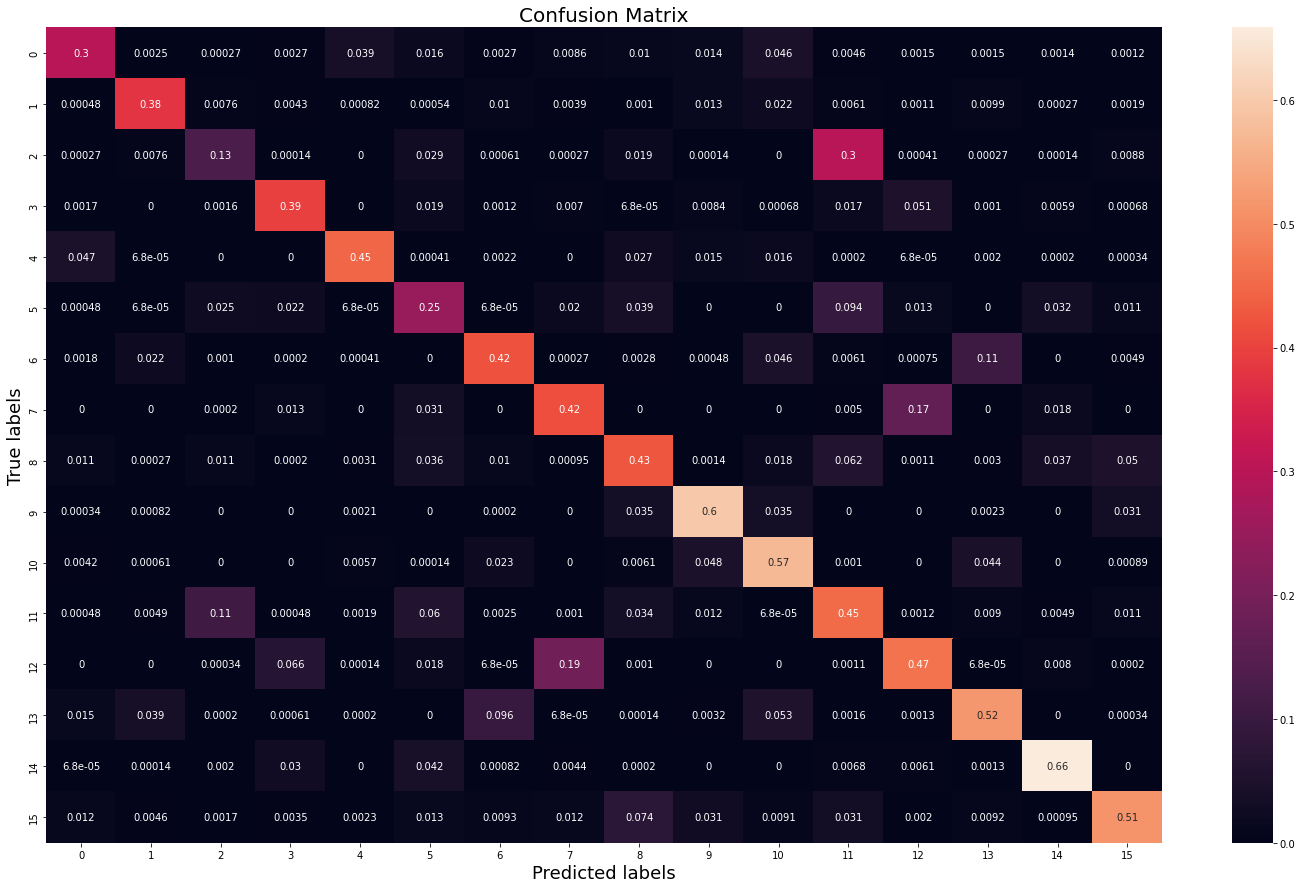

In [62]:
# constant for classes
classes = tuple()

for label in dim_label.iterrows():
  classes += (label[0],)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (25,15))
ax = plt.subplot()
sn.heatmap(df_cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels', fontsize=18)
ax.set_ylabel('True labels', fontsize=18)
ax.set_title('Confusion Matrix', fontsize=20)